In [1]:
!pip install PyPortfolioOpt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
import yfinance as yf

In [3]:
#downloading data
tickers = ['MSFT', 'AAPL', 'GE', 'GM', 'XOM', 'EA', 'KO']
df_assets = yf.download(tickers, start='2011-01-01', end='2019-12-31')['Adj Close']

df_assets

[*********************100%%**********************]  7 of 7 completed


Ticker,AAPL,EA,GE,GM,KO,MSFT,XOM
Date,,,,,,,
2011-01-03,9.951280,16.041300,61.319588,28.129126,21.643812,21.585320,44.193878
2011-01-04,10.003216,16.041300,62.426563,28.766703,21.195799,21.670176,44.401375
2011-01-05,10.085042,15.943370,62.527199,28.895744,21.069700,21.600748,44.282818
2011-01-06,10.076893,15.894401,62.258842,29.525719,20.917044,22.233335,44.567364
2011-01-07,10.149055,15.718124,61.822762,29.586437,20.880541,22.063614,44.810410
...,...,...,...,...,...,...,...
2019-12-23,68.988724,105.561165,54.454571,35.674572,48.077919,151.133667,56.053402
2019-12-24,69.054337,106.305443,54.600952,35.490234,47.902805,151.104858,55.838085
2019-12-26,70.424393,106.266273,54.796135,35.393211,48.174229,152.343414,55.925800


In [4]:
nullin_df = pd.DataFrame(df_assets,columns=tickers)
print(nullin_df.isnull().sum())

MSFT    0
AAPL    0
GE      0
GM      0
XOM     0
EA      0
KO      0
dtype: int64


In [5]:
#data for base model
df_sample_data = df_assets[:'2017-12-31']

df_sample_data

Ticker,AAPL,EA,GE,GM,KO,MSFT,XOM
Date,,,,,,,
2011-01-03,9.951280,16.041300,61.319588,28.129126,21.643812,21.585320,44.193878
2011-01-04,10.003216,16.041300,62.426563,28.766703,21.195799,21.670176,44.401375
2011-01-05,10.085042,15.943370,62.527199,28.895744,21.069700,21.600748,44.282818
2011-01-06,10.076893,15.894401,62.258842,29.525719,20.917044,22.233335,44.567364
2011-01-07,10.149055,15.718124,61.822762,29.586437,20.880541,22.063614,44.810410
...,...,...,...,...,...,...,...
2017-12-22,41.264290,103.827751,78.203506,37.585381,37.398090,79.527512,61.359215
2017-12-26,40.217411,102.887611,78.565727,37.388596,37.578552,79.425224,61.366535
2017-12-27,40.224487,103.054115,78.340332,36.950306,37.676991,79.713509,61.308079


In [6]:
#Daily returns
mu = expected_returns.mean_historical_return(df_sample_data)
#Portfolio variance
Sigma = risk_models.sample_cov(df_sample_data)

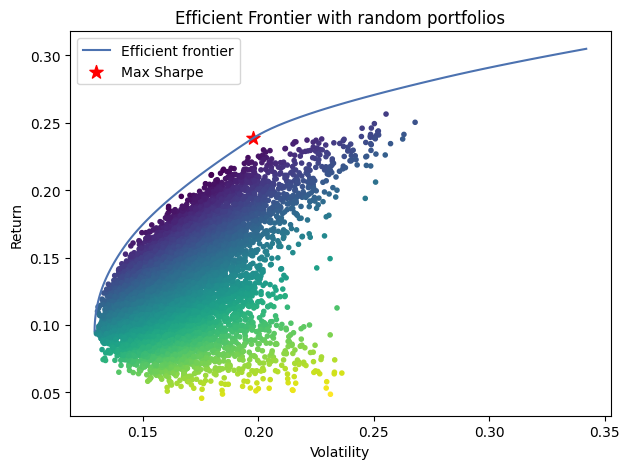

In [7]:
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
pplt.plot_efficient_frontier(ef, ax=ax, show_assets=False)

ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [8]:
#Maximal Sharp coefficient
ef_sharp_sample = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef_sharp_sample.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef_sharp_sample.clean_weights()
print(sharpe_pwt)

OrderedDict([('AAPL', 0.33314), ('EA', 0.28366), ('GE', 0.0), ('GM', 0.0), ('KO', 0.0), ('MSFT', 0.3832), ('XOM', 0.0)])


In [9]:
ef.portfolio_performance(verbose=True)

Expected annual return: 30.5%
Annual volatility: 34.2%
Sharpe Ratio: 0.83


(0.3047597450462313, 0.34200639003962624, 0.832615276612925)

In [10]:
#showing results of portflolio
def PortfolioPerformance (weights, data):

  results = pd.DataFrame(columns=['date', 'daily_price', 'daily_returns'])
  for index in data.index:
    daily_price = 0

    for ticker in data.columns:
      daily_price += data.at[index, ticker] * weights[ticker]

    results.loc[len(results.index)] = [index, daily_price, 0]

  results.set_index('date', inplace=True)
  for i in range(1, len(results.index)):
    results.at[results.index[i], 'daily_returns'] = (results.at[results.index[i], 'daily_price'] -
                                      results.at[results.index[i-1], 'daily_price']) / results.at[results.index[i-1], 'daily_price'] + results.at[results.index[i-1], 'daily_returns']

  return results

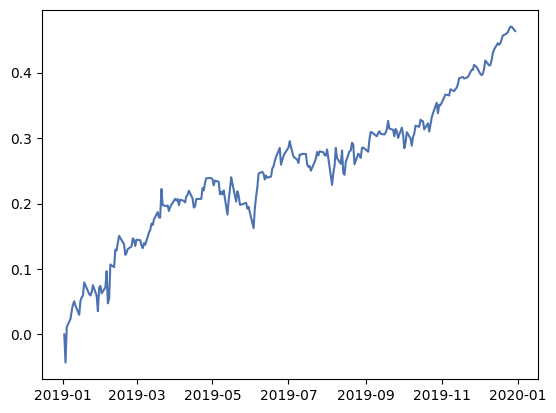

In [11]:
sample_res = PortfolioPerformance(sharpe_pwt, df_assets['2019-01-01':'2019-12-31'])
plt.plot(sample_res['daily_returns'])

# **Data preprocessing**

In [12]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

In [13]:
#data for training and validation
data = df_assets['2011-01-01':'2018-12-31']
data

Ticker,AAPL,EA,GE,GM,KO,MSFT,XOM
Date,,,,,,,
2011-01-03,9.951280,16.041300,61.319588,28.129126,21.643812,21.585320,44.193878
2011-01-04,10.003216,16.041300,62.426563,28.766703,21.195799,21.670176,44.401375
2011-01-05,10.085042,15.943370,62.527199,28.895744,21.069700,21.600748,44.282818
2011-01-06,10.076893,15.894401,62.258842,29.525719,20.917044,22.233335,44.567364
2011-01-07,10.149055,15.718124,61.822762,29.586437,20.880541,22.063614,44.810410
...,...,...,...,...,...,...,...
2018-12-24,35.139698,73.174973,32.304417,30.138248,39.005562,89.059967,49.853817
2018-12-26,37.614292,76.279419,34.498505,31.208969,39.837284,95.143623,52.235775
2018-12-27,37.370174,77.787575,33.938301,31.618633,40.338001,95.730225,52.464092


In [14]:
#creating time intervals for train and validation, normalizing of the data
def DataSplit(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [15]:
#splitting data
def LoadingData(data, ticker, train_split, val_split):
  results = data[ticker]
  results.index = data.index

  mean = results[:train_split].mean()
  std = results[:train_split].std()
  results = (results - mean) / std

  past_history = 20
  future_target = 0

  x_train, y_train = DataSplit(results, 0, train_split, 20, 0)
  x_val, y_val = DataSplit(results, train_split, val_split, 20, 0)

  return x_train, y_train, x_val, y_val

In [16]:
#transforming data into tensors
def Butching(x_train, y_train, x_val, y_val):
  batch_size = 256
  buffer_size = 1000

  train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val = val.batch(batch_size).repeat()

  return train, val

# **Model training**

In [17]:
#model defining and training
def TrainModel(train, val):
  lstm_model = tf.keras.models.Sequential()
  lstm_model.add(tf.keras.layers.LSTM(32,
                                      return_sequences=True,
                                      input_shape=x_train_AAPL.shape[-2:]))
  lstm_model.add(tf.keras.layers.LSTM(16, activation='sigmoid'))
  lstm_model.add(tf.keras.layers.Dense(1))

  lstm_model.compile(optimizer='adam', loss='mae')

  lstm_model.fit(train, epochs=10,
                      steps_per_epoch=200,
                      validation_data=val, validation_steps=50)

  return lstm_model

In [18]:
#prediction of the results
def Prediction(lstm_model, test_data):
  results = []
  buffer = test_data

  for i in range(251):
    x = lstm_model.predict(buffer)[0]
    results.append(x[0])
    buffer = np.reshape(np.delete(buffer, 0, 0), (19, 1))
    buffer = np.reshape(np.append(buffer, [results[i]]), (20, 1))

  return results

# **Models**

In [19]:
train_split = 1761
val_split = train_split + 251

### Apple

In [20]:
ticker = 'AAPL'
x_train_AAPL, y_train_AAPL, x_val_AAPL, y_val_AAPL = LoadingData(data, ticker, train_split, val_split)
train_AAPL, val_AAPL = Butching(x_train_AAPL, y_train_AAPL, x_val_AAPL, y_val_AAPL)

In [21]:
print ('Single window of past history')
print (x_train_AAPL[0])
print ('\n Target temperature to predict')
print (y_train_AAPL[0])

Single window of past history
[[-1.44758519]
 [-1.44101341]
 [-1.43065947]
 [-1.43169062]
 [-1.42255947]
 [-1.39837436]
 [-1.40146856]
 [-1.39084745]
 [-1.3860334 ]
 [-1.37533554]
 [-1.40525169]
 [-1.41216715]
 [-1.43570255]
 [-1.45847432]
 [-1.41747753]
 [-1.40238641]
 [-1.39302549]
 [-1.39547034]
 [-1.42263586]
 [-1.41033315]]

 Target temperature to predict
-1.3885167508217793


In [22]:
model_AAPL = TrainModel(train_AAPL, val_AAPL)

Epoch 1/10
200/200 [==============================] - 16s 39ms/step - loss: 0.2255 - val_loss: 0.7497
Epoch 2/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0543 - val_loss: 0.5793
Epoch 3/10
200/200 [==============================] - 8s 38ms/step - loss: 0.0465 - val_loss: 0.5180
Epoch 4/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0420 - val_loss: 0.4756
Epoch 5/10
200/200 [==============================] - 8s 39ms/step - loss: 0.0384 - val_loss: 0.4597
Epoch 6/10
200/200 [==============================] - 7s 33ms/step - loss: 0.0354 - val_loss: 0.4298
Epoch 7/10
200/200 [==============================] - 7s 37ms/step - loss: 0.0340 - val_loss: 0.4141
Epoch 8/10
200/200 [==============================] - 7s 33ms/step - loss: 0.0331 - val_loss: 0.4016
Epoch 9/10
200/200 [==============================] - 8s 40ms/step - loss: 0.0318 - val_loss: 0.3962
Epoch 10/10
200/200 [==============================] - 7s 37ms/step - loss: 0.0311 - val_l

In [23]:
result_AAPL = Prediction(model_AAPL, x_val_AAPL[len(x_val_AAPL)-1])

1/1 [==============================] - 0s 19ms/step


In [24]:
result_AAPL = pd.DataFrame({ticker: result_AAPL})
result_AAPL['c_returns'] = 0
for i in range(1, len(result_AAPL.index)):
    result_AAPL.at[result_AAPL.index[i], 'c_returns'] = (result_AAPL.at[result_AAPL.index[i], 'AAPL'] -
                                      result_AAPL.at[result_AAPL.index[i-1], 'AAPL']) / result_AAPL.at[result_AAPL.index[i-1], 'AAPL'] + result_AAPL.at[result_AAPL.index[i-1], 'c_returns']
result_AAPL

,AAPL,c_returns
0,0.810283,0.000000
1,0.803902,-0.007875
2,0.843831,0.041795
3,0.791280,-0.020482
4,0.777858,-0.037445
...,...,...
246,-0.080904,-3.600878
247,-0.080904,-3.600878
248,-0.080904,-3.600878
249,-0.080904,-3.600878


### MSFT

In [25]:
ticker = 'MSFT'
x_train_MSFT, y_train_MSFT, x_val_MSFT, y_val_MSFT = LoadingData(data, ticker, train_split, val_split)
train_MSFT, val_MSFT = Butching(x_train_MSFT, y_train_MSFT, x_val_MSFT, y_val_MSFT)

In [26]:
model_MSFT = TrainModel(train_MSFT, val_MSFT)

Epoch 1/10
200/200 [==============================] - 10s 38ms/step - loss: 0.2211 - val_loss: 1.4486
Epoch 2/10
200/200 [==============================] - 7s 37ms/step - loss: 0.0439 - val_loss: 1.0803
Epoch 3/10
200/200 [==============================] - 8s 42ms/step - loss: 0.0381 - val_loss: 1.0154
Epoch 4/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0358 - val_loss: 0.9493
Epoch 5/10
200/200 [==============================] - 8s 38ms/step - loss: 0.0343 - val_loss: 0.9108
Epoch 6/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0321 - val_loss: 0.8713
Epoch 7/10
200/200 [==============================] - 7s 38ms/step - loss: 0.0306 - val_loss: 0.8450
Epoch 8/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0290 - val_loss: 0.8174
Epoch 9/10
200/200 [==============================] - 7s 36ms/step - loss: 0.0278 - val_loss: 0.7947
Epoch 10/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0262 - val_l

In [27]:
result_MSFT = Prediction(model_MSFT, x_val_MSFT[len(x_val_MSFT)-1])

1/1 [==============================] - 0s 18ms/step


In [28]:
result_MSFT = pd.DataFrame({ticker: result_MSFT})
result_MSFT['c_returns'] = 0
for i in range(1, len(result_MSFT.index)):
    result_MSFT.at[result_MSFT.index[i], 'c_returns'] = (result_MSFT.at[result_MSFT.index[i], 'MSFT'] -
                                      result_MSFT.at[result_MSFT.index[i-1], 'MSFT']) / result_MSFT.at[result_MSFT.index[i-1], 'MSFT'] + result_MSFT.at[result_MSFT.index[i-1], 'c_returns']
result_MSFT

,MSFT,c_returns
0,1.293709,0.000000
1,1.298746,0.003893
2,1.307204,0.010405
3,1.281380,-0.009350
4,1.286380,-0.005447
...,...,...
246,0.402708,-0.978802
247,0.402708,-0.978802
248,0.402708,-0.978802
249,0.402708,-0.978802


### GE

In [29]:
ticker = 'GE'
x_train_GE, y_train_GE, x_val_GE, y_val_GE = LoadingData(data, ticker, train_split, val_split)
train_GE, val_GE = Butching(x_train_GE, y_train_GE, x_val_GE, y_val_GE)

In [30]:
model_GE = TrainModel(train_GE, val_GE)

Epoch 1/10
200/200 [==============================] - 11s 38ms/step - loss: 0.2477 - val_loss: 0.1697
Epoch 2/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0645 - val_loss: 0.1406
Epoch 3/10
200/200 [==============================] - 7s 37ms/step - loss: 0.0556 - val_loss: 0.1209
Epoch 4/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0499 - val_loss: 0.1012
Epoch 5/10
200/200 [==============================] - 7s 36ms/step - loss: 0.0453 - val_loss: 0.0926
Epoch 6/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0421 - val_loss: 0.0880
Epoch 7/10
200/200 [==============================] - 7s 37ms/step - loss: 0.0406 - val_loss: 0.0985
Epoch 8/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0396 - val_loss: 0.0845
Epoch 9/10
200/200 [==============================] - 7s 35ms/step - loss: 0.0392 - val_loss: 0.0830
Epoch 10/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0380 - val_l

In [31]:
result_GE = Prediction(model_GE, x_val_GE[len(x_val_GE)-1])

1/1 [==============================] - 0s 30ms/step


In [32]:
result_GE = pd.DataFrame({ticker: result_GE})
result_GE['c_returns'] = 0
for i in range(1, len(result_GE.index)):
    result_GE.at[result_GE.index[i], 'c_returns'] = (result_GE.at[result_GE.index[i], 'GE'] -
                                      result_GE.at[result_GE.index[i-1], 'GE']) / result_GE.at[result_GE.index[i-1], 'GE'] + result_GE.at[result_GE.index[i-1], 'c_returns']
result_GE

,GE,c_returns
0,-0.759053,0.000000
1,-0.776630,0.023156
2,-0.764303,0.007284
3,-0.785214,0.034643
4,-0.782497,0.031184
...,...,...
246,-0.070812,-1.688222
247,-0.070812,-1.688222
248,-0.070812,-1.688222
249,-0.070812,-1.688222


### GM

In [33]:
ticker = 'GM'
x_train_GM, y_train_GM, x_val_GM, y_val_GM = LoadingData(data, ticker, train_split, val_split)
train_GM, val_GM = Butching(x_train_GM, y_train_GM, x_val_GM, y_val_GM)

In [34]:
model_GM = TrainModel(train_GM, val_GM)

Epoch 1/10
200/200 [==============================] - 11s 40ms/step - loss: 0.2494 - val_loss: 0.2153
Epoch 2/10
200/200 [==============================] - 7s 36ms/step - loss: 0.0891 - val_loss: 0.1670
Epoch 3/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0744 - val_loss: 0.1707
Epoch 4/10
200/200 [==============================] - 7s 34ms/step - loss: 0.0667 - val_loss: 0.1858
Epoch 5/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0642 - val_loss: 0.1988
Epoch 6/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0621 - val_loss: 0.1609
Epoch 7/10
200/200 [==============================] - 7s 33ms/step - loss: 0.0615 - val_loss: 0.1835
Epoch 8/10
200/200 [==============================] - 7s 33ms/step - loss: 0.0609 - val_loss: 0.1574
Epoch 9/10
200/200 [==============================] - 7s 33ms/step - loss: 0.0604 - val_loss: 0.1474
Epoch 10/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0604 - val_l

In [35]:
result_GM = Prediction(model_GM, x_val_GM[len(x_val_GM)-1])

1/1 [==============================] - 0s 16ms/step


In [36]:
result_GM = pd.DataFrame({ticker: result_GM})
result_GM['c_returns'] = 0
for i in range(1, len(result_GM.index)):
    result_GM.at[result_GM.index[i], 'c_returns'] = (result_GM.at[result_GM.index[i], 'GM'] -
                                      result_GM.at[result_GM.index[i-1], 'GM']) / result_GM.at[result_GM.index[i-1], 'GM'] + result_GM.at[result_GM.index[i-1], 'c_returns']
result_GM

,GM,c_returns
0,0.540351,0.000000
1,0.588412,0.088944
2,0.607198,0.120870
3,0.530068,-0.006157
4,0.510480,-0.043110
...,...,...
246,0.018330,-2.685879
247,0.018330,-2.685876
248,0.018331,-2.685849
249,0.018330,-2.685864


### XOM

In [37]:
ticker = 'XOM'
x_train_XOM, y_train_XOM, x_val_XOM, y_val_XOM = LoadingData(data, ticker, train_split, val_split)
train_XOM, val_XOM = Butching(x_train_XOM, y_train_XOM, x_val_XOM, y_val_XOM)

In [38]:
model_XOM = TrainModel(train_XOM, val_XOM)

Epoch 1/10
200/200 [==============================] - 10s 31ms/step - loss: 0.2580 - val_loss: 0.1841
Epoch 2/10
200/200 [==============================] - 7s 36ms/step - loss: 0.1093 - val_loss: 0.1388
Epoch 3/10
200/200 [==============================] - 6s 29ms/step - loss: 0.0925 - val_loss: 0.1278
Epoch 4/10
200/200 [==============================] - 7s 36ms/step - loss: 0.0877 - val_loss: 0.1228
Epoch 5/10
200/200 [==============================] - 6s 29ms/step - loss: 0.0866 - val_loss: 0.1224
Epoch 6/10
200/200 [==============================] - 7s 37ms/step - loss: 0.0863 - val_loss: 0.1210
Epoch 7/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0861 - val_loss: 0.1205
Epoch 8/10
200/200 [==============================] - 7s 36ms/step - loss: 0.0862 - val_loss: 0.1202
Epoch 9/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0859 - val_loss: 0.1200
Epoch 10/10
200/200 [==============================] - 7s 37ms/step - loss: 0.0859 - val_l

In [39]:
result_XOM = Prediction(model_XOM, x_val_XOM[len(x_val_XOM)-1])

1/1 [==============================] - 0s 19ms/step


In [40]:
result_XOM = pd.DataFrame({ticker: result_XOM})
result_XOM['c_returns'] = 0
for i in range(1, len(result_XOM.index)):
    result_XOM.at[result_XOM.index[i], 'c_returns'] = (result_XOM.at[result_XOM.index[i], 'XOM'] -
                                      result_XOM.at[result_XOM.index[i-1], 'XOM']) / result_XOM.at[result_XOM.index[i-1], 'XOM'] + result_XOM.at[result_XOM.index[i-1], 'c_returns']
result_XOM

,XOM,c_returns
0,0.248883,0.000000
1,0.269244,0.081809
2,0.346144,0.367424
3,0.266023,0.135956
4,0.217406,-0.046799
...,...,...
246,0.016959,-21.952293
247,0.016959,-21.952293
248,0.016959,-21.952297
249,0.016959,-21.952288


### EA

In [41]:
ticker = 'EA'
x_train_EA, y_train_EA, x_val_EA, y_val_EA = LoadingData(data, ticker, train_split, val_split)
train_EA, val_EA = Butching(x_train_EA, y_train_EA, x_val_EA, y_val_EA)

In [42]:
model_EA = TrainModel(train_EA, val_EA)

Epoch 1/10
200/200 [==============================] - 12s 45ms/step - loss: 0.2056 - val_loss: 0.3054
Epoch 2/10
200/200 [==============================] - 7s 34ms/step - loss: 0.0387 - val_loss: 0.2170
Epoch 3/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0348 - val_loss: 0.1831
Epoch 4/10
200/200 [==============================] - 7s 35ms/step - loss: 0.0320 - val_loss: 0.1645
Epoch 5/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0296 - val_loss: 0.1517
Epoch 6/10
200/200 [==============================] - 7s 36ms/step - loss: 0.0272 - val_loss: 0.1434
Epoch 7/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0260 - val_loss: 0.1384
Epoch 8/10
200/200 [==============================] - 7s 36ms/step - loss: 0.0239 - val_loss: 0.1240
Epoch 9/10
200/200 [==============================] - 6s 30ms/step - loss: 0.0226 - val_loss: 0.1152
Epoch 10/10
200/200 [==============================] - 7s 35ms/step - loss: 0.0220 - val_l

In [43]:
result_EA = Prediction(model_EA, x_val_EA[len(x_val_EA)-1])

1/1 [==============================] - 0s 19ms/step


In [44]:
result_EA = pd.DataFrame({ticker: result_EA})
result_EA['c_returns'] = 0
for i in range(1, len(result_EA.index)):
    result_EA.at[result_EA.index[i], 'c_returns'] = (result_EA.at[result_EA.index[i], 'EA'] -
                                      result_EA.at[result_EA.index[i-1], 'EA']) / result_EA.at[result_EA.index[i-1], 'EA'] + result_EA.at[result_EA.index[i-1], 'c_returns']
result_EA

,EA,c_returns
0,0.484823,0.000000
1,0.459308,-0.052626
2,0.458531,-0.054320
3,0.426841,-0.123432
4,0.457197,-0.052313
...,...,...
246,0.024041,-2.475273
247,0.024040,-2.475276
248,0.024040,-2.475280
249,0.024040,-2.475295


### KO

In [45]:
ticker = 'KO'
x_train_KO, y_train_KO, x_val_KO, y_val_KO = LoadingData(data, ticker, train_split, val_split)
train_KO, val_KO = Butching(x_train_KO, y_train_KO, x_val_KO, y_val_KO)

In [46]:
model_KO = TrainModel(train_KO, val_KO)

Epoch 1/10
200/200 [==============================] - 12s 44ms/step - loss: 0.2130 - val_loss: 0.2272
Epoch 2/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0689 - val_loss: 0.1738
Epoch 3/10
200/200 [==============================] - 8s 40ms/step - loss: 0.0572 - val_loss: 0.1505
Epoch 4/10
200/200 [==============================] - 7s 33ms/step - loss: 0.0506 - val_loss: 0.1264
Epoch 5/10
200/200 [==============================] - 7s 34ms/step - loss: 0.0477 - val_loss: 0.1251
Epoch 6/10
200/200 [==============================] - 8s 41ms/step - loss: 0.0456 - val_loss: 0.1254
Epoch 7/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0447 - val_loss: 0.1165
Epoch 8/10
200/200 [==============================] - 8s 41ms/step - loss: 0.0440 - val_loss: 0.1155
Epoch 9/10
200/200 [==============================] - 6s 31ms/step - loss: 0.0435 - val_loss: 0.1104
Epoch 10/10
200/200 [==============================] - 7s 37ms/step - loss: 0.0429 - val_l

In [47]:
result_KO = Prediction(model_KO, x_val_KO[len(x_val_KO)-1])

1/1 [==============================] - 0s 18ms/step


In [48]:
result_KO = pd.DataFrame({ticker: result_KO})
result_KO['c_returns'] = 0
for i in range(1, len(result_KO.index)):
    result_KO.at[result_KO.index[i], 'c_returns'] = (result_KO.at[result_KO.index[i], 'KO'] -
                                      result_KO.at[result_KO.index[i-1], 'KO']) / result_KO.at[result_KO.index[i-1], 'KO'] + result_KO.at[result_KO.index[i-1], 'c_returns']
result_KO

,KO,c_returns
0,0.661759,0.000000
1,0.701252,0.059679
2,0.682068,0.032322
3,0.678997,0.027819
4,0.673343,0.019493
...,...,...
246,-0.069142,-5.350165
247,-0.069142,-5.350165
248,-0.069142,-5.350165
249,-0.069142,-5.350165


# **Final results**

In [49]:
new_data = pd.DataFrame({'AAPL': result_AAPL['AAPL'],
                         'MSFT': result_MSFT['MSFT'],
                         'GE': result_GE['GE'],
                         'GM': result_GM['GM'],
                         'EA': result_EA['EA'],
                         'XOM': result_XOM['XOM'],
                         'KO': result_KO['KO']})
new_data

,AAPL,MSFT,GE,GM,EA,XOM,KO
0,0.810283,1.293709,-0.759053,0.540351,0.484823,0.248883,0.661759
1,0.803902,1.298746,-0.776630,0.588412,0.459308,0.269244,0.701252
2,0.843831,1.307204,-0.764303,0.607198,0.458531,0.346144,0.682068
3,0.791280,1.281380,-0.785214,0.530068,0.426841,0.266023,0.678997
4,0.777858,1.286380,-0.782497,0.510480,0.457197,0.217406,0.673343
...,...,...,...,...,...,...,...
246,-0.080904,0.402708,-0.070812,0.018330,0.024041,0.016959,-0.069142
247,-0.080904,0.402708,-0.070812,0.018330,0.024040,0.016959,-0.069142
248,-0.080904,0.402708,-0.070812,0.018331,0.024040,0.016959,-0.069142
249,-0.080904,0.402708,-0.070812,0.018330,0.024040,0.016959,-0.069142


In [50]:
new_data_returns = pd.DataFrame({'AAPL': result_AAPL['c_returns'],
                         'MSFT': result_MSFT['c_returns'],
                         'GE': result_GE['c_returns'],
                         'GM': result_GM['c_returns'],
                         'EA': result_EA['c_returns'],
                         'XOM': result_XOM['c_returns'],
                         'KO': result_KO['c_returns']})
new_data_returns

,AAPL,MSFT,GE,GM,EA,XOM,KO
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.007875,0.003893,0.023156,0.088944,-0.052626,0.081809,0.059679
2,0.041795,0.010405,0.007284,0.120870,-0.054320,0.367424,0.032322
3,-0.020482,-0.009350,0.034643,-0.006157,-0.123432,0.135956,0.027819
4,-0.037445,-0.005447,0.031184,-0.043110,-0.052313,-0.046799,0.019493
...,...,...,...,...,...,...,...
246,-3.600878,-0.978802,-1.688222,-2.685879,-2.475273,-21.952293,-5.350165
247,-3.600878,-0.978802,-1.688222,-2.685876,-2.475276,-21.952293,-5.350165
248,-3.600878,-0.978802,-1.688222,-2.685849,-2.475280,-21.952297,-5.350165
249,-3.600878,-0.978802,-1.688222,-2.685864,-2.475295,-21.952288,-5.350165


As we can see, the model results are biased to the left and the further away the prediction horizon is, the larger the bias. This is due to the accumulation of error. However, the results that are close in time to the real data can be used for portfolio formation (in real work the prediction horizon should be at least half a year, but for accurate prediction for half a year it is necessary to increase the data vector to a similar time interval or more, which means an increase in computing power).

In [77]:
data_for_model_prices = new_data[:10]
data_for_model_returns = new_data_returns[:10]

#Daily returns
mu = pd.Series([np.mean(data_for_model_returns['AAPL']),
                   np.mean(data_for_model_returns['MSFT']),
                   np.mean(data_for_model_returns['GE']),
                   np.mean(data_for_model_returns['GM']),
                   np.mean(data_for_model_returns['EA']),
                   np.mean(data_for_model_returns['XOM']),
                   np.mean(data_for_model_returns['KO'])], index=new_data_returns.columns)
#Portfolio variance
Sigma = risk_models.sample_cov(data_for_model_prices)

In [78]:
#Maximal Sharp coefficient
ef_sharp_sample = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef_sharp_sample.max_sharpe(risk_free_rate=-3.00) #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef_sharp_sample.clean_weights()
print(sharpe_pwt)

OrderedDict([('AAPL', 0.09516), ('MSFT', 0.11), ('GE', 0.6604), ('GM', 0.0), ('EA', 0.11008), ('XOM', 0.02436), ('KO', 0.0)])


In [79]:
ef.portfolio_performance(verbose=True)

Expected annual return: 30.5%
Annual volatility: 34.2%
Sharpe Ratio: 0.83


(0.3047597450462313, 0.34200639003962624, 0.832615276612925)

As we can see, the Sharpe ratio of the new portel, is very close to baseline. Let's take a look at the yield chart of this portfolio for 2019.

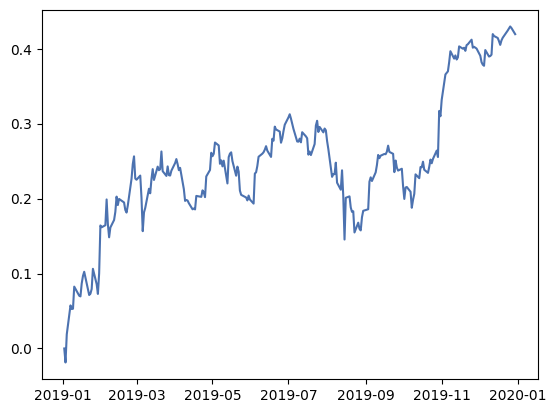

In [81]:
res = PortfolioPerformance(sharpe_pwt, df_assets['2019-01-01':'2019-12-31'])
plt.plot(res['daily_returns'])

The total return of the new portfolio is slightly less than the baseline portfolio. However, we can see that the volatility of the portfolio is actually higher. This can be solved by increasing the forecasting horizon, as mentioned above.